In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import timm  # if you need any timm utilities

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Directory paths (update these paths if needed)
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir   = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir  = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transform)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

# Get class names (for example: ['NORMAL', 'PNEUMONIA'])
class_names = train_dataset.classes
print("Classes:", class_names)


Train samples: 5216
Validation samples: 16
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


''

In [3]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [4]:
# Option 1: Using torchvision's DenseNet121 (CheXNet style)
model = models.densenet121(pretrained=True)
# The classifier in DenseNet121 is named 'classifier'
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(device)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/30 - Train Loss: 0.1079, Train Acc: 0.9617 | Test Loss: 0.4143, Test Acc: 0.8814
Epoch 2/30 - Train Loss: 0.0306, Train Acc: 0.9916 | Test Loss: 1.2094, Test Acc: 0.7452
Epoch 3/30 - Train Loss: 0.0251, Train Acc: 0.9918 | Test Loss: 0.9288, Test Acc: 0.7708
Epoch 4/30 - Train Loss: 0.0133, Train Acc: 0.9960 | Test Loss: 0.9173, Test Acc: 0.7997
Epoch 5/30 - Train Loss: 0.0135, Train Acc: 0.9962 | Test Loss: 1.0478, Test Acc: 0.7564
Epoch 6/30 - Train Loss: 0.0091, Train Acc: 0.9969 | Test Loss: 1.1409, Test Acc: 0.7548
Epoch 7/30 - Train Loss: 0.0052, Train Acc: 0.9987 | Test Loss: 0.9566, Test Acc: 0.8061
Epoch 8/30 - Train Loss: 0.0095, Train Acc: 0.9973 | Test Loss: 1.1585, Test Acc: 0.7885
Epoch 9/30 - Train Loss: 0.0051, Train Acc: 0.9987 | Test Loss: 1.0983, Test Acc: 0.7837
Epoch 10/30 - Train Loss: 0.0023, Train Acc: 0.9996 | Test Loss: 1.2624, Test Acc: 0.7692
Epoch 11/30 - Train Loss: 0.0013, Train Acc: 1.0000 | Test Loss: 1.2568, Test Acc: 0.7692
Epoch 12/30 - Train

In [7]:
torch.save(model.state_dict(), "chexnext_model.pth")
print("Model saved.")


Model saved.


Final Test Loss: 1.5495, Final Test Accuracy: 0.7933


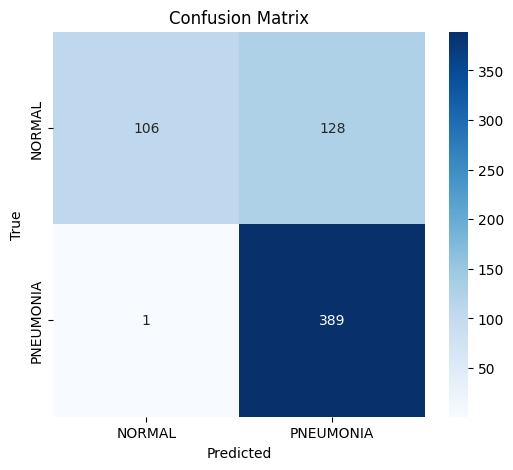

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.45      0.62       234
   PNEUMONIA       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

# Compute predictions and true labels on test set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


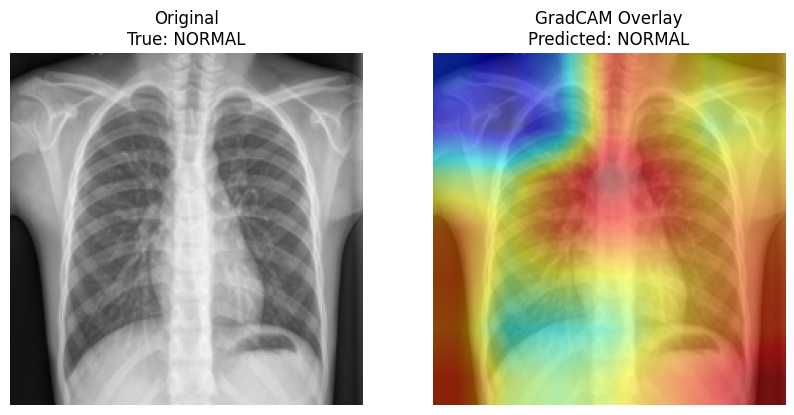

In [9]:
# GradCAM implementation for DenseNet-121
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([handle_forward, handle_backward])
    
    def generate_cam(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        score = output[0, class_idx]
        score.backward()
        gradients = self.gradients  # shape: [1, C, H, W]
        activations = self.activations  # shape: [1, C, H, W]
        weights = torch.mean(gradients, dim=(2,3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()[0]
        cam = cv2.resize(cam, (224, 224))
        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

def show_gradcam(model, img_tensor, true_label, class_names):
    model.eval()
    # For DenseNet-121, we can use model.features.norm5 as the target layer.
    target_layer = model.features.norm5  
    grad_cam = GradCAM(model, target_layer)
    
    input_tensor = img_tensor.unsqueeze(0).to(device)
    cam = grad_cam.generate_cam(input_tensor)
    
    # Denormalize the image for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_denorm = inv_normalize(img_tensor).cpu().numpy().transpose((1,2,0))
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Create heatmap and overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img_denorm)
    overlay = overlay / np.max(overlay)
    
    # Get model prediction
    output = model(input_tensor)
    _, pred = torch.max(output, 1)
    pred_label = class_names[pred.item()]
    true_label_str = class_names[true_label]
    
    # Plot side by side
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(img_denorm)
    axs[0].set_title(f"Original\nTrue: {true_label_str}")
    axs[0].axis('off')
    axs[1].imshow(overlay)
    axs[1].set_title(f"GradCAM Overlay\nPredicted: {pred_label}")
    axs[1].axis('off')
    plt.show()
    
    grad_cam.remove_hooks()

# Example usage: Pick a random image from the test set and visualize
inputs, labels = next(iter(test_loader))
idx = random.randint(0, inputs.size(0) - 1)
show_gradcam(model, inputs[idx], labels[idx].item(), class_names)
